# Awesome Audio Mixer
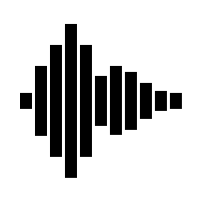

## Import libs

In [1]:
#! pip install soundfile
#! pip install youtube_dl
#! sudo apt install ffmpeg

In [2]:
from __future__ import unicode_literals
import youtube_dl
import wave
import numpy as np
from scipy.fftpack import fft,fftfreq
import matplotlib.pyplot as plt
import scipy.io
import soundfile as sf
import scipy.constants as const
import scipy
from IPython.core.display import HTML
from __future__ import division
# from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pynq import Overlay, allocate
import struct
import time 



## Constants

In [3]:
SAMPLERATE = 44100
FILTER_SIZE = 51

## Download song from youtube

In [4]:
url = 'https://www.youtube.com/watch?v=etAIpkdhU9Q'
ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
    'postprocessor_args': [
        '-ar', str(SAMPLERATE)
    ]
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

[youtube] etAIpkdhU9Q: Downloading webpage
[download] Destination: AC_DC - Hells Bells (Official Video)-etAIpkdhU9Q.webm
[download] 100% of 4.79MiB in 00:0092MiB/s ETA 00:005
[ffmpeg] Destination: AC_DC - Hells Bells (Official Video)-etAIpkdhU9Q.wav
Deleting original file AC_DC - Hells Bells (Official Video)-etAIpkdhU9Q.webm (pass -k to keep)


In [5]:
# source: https://nbviewer.jupyter.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb
# description:  wrapper that takes a filename and publish an html <audio> tag to listen to it
    # filepath: dstring
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

In [6]:
print("Try out the song right now!")
wavPlayer("AC_DC - Hells Bells (Official Video)-etAIpkdhU9Q.wav")

Try out the song right now!


## Get user settings

In [7]:
# description: create silder and display them
def slider():
    global gain_bass_slider, gain_mid_slider, gain_treble_slider
    
    gain_bass_slider = widgets.IntSlider(
        min=0,
        max=150,
        step=1,
        description='BASS [%]:',
        value=50
    )
    gain_mid_slider = widgets.IntSlider(
        min=0,
        max=150,
        step=1,
        description='MID [%]:',
        value=120
    )
    gain_treble_slider = widgets.IntSlider(
        min=0,
        max=150,
        step=1,
        description='TREBLE [%]:',
        value=100
    )
    
    display(gain_bass_slider)
    display(gain_mid_slider)
    display(gain_treble_slider)
    

In [8]:
print("Please adjust the silder values!")
slider()


Please adjust the silder values!


IntSlider(value=50, description='BASS [%]:', max=150)

IntSlider(value=120, description='MID [%]:', max=150)

IntSlider(value=100, description='TREBLE [%]:', max=150)

In [9]:
print("Slider values for further processing saved!")
gain_bass = gain_bass_slider.value/100.0
gain_mid  = gain_mid_slider.value/100.0
gain_treble = gain_treble_slider.value/100.0

Slider values for further processing saved!


## Convert wave file to numpy array

In [10]:
# Read file to get buffer                                                                                               
wave_obj = wave.open("AC_DC - Hells Bells (Official Video)-etAIpkdhU9Q.wav")
samples = wave_obj.getnframes()
audio = wave_obj.readframes(samples)
print(wave_obj.getparams())

# Save samples as numpy array                                                                              
audio = np.frombuffer(audio, dtype=np.int16)
# Convert integer values to floats
audio = audio.astype(np.float32)

_wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=13634848, comptype='NONE', compname='not compressed')


In [11]:
# Extract channels form audio
leftchan  = audio[0::2] # Extract left audio channel
rightchan = audio[1::2] # Extract right audio channel

# Slice just a little window from audio file otherwise it takes to much time to process samples
leftchan = leftchan[8000000:8080000]
rightchan = rightchan[8000000:8080000]

print('Slicing successfull!')

Slicing successfull!


## Test FFT 

In [12]:
# description: function to apply fft to sample values and plot them
    # data: tuple of numpy array of np.float32
    # title: tuple of string
    # color_plot: tuple of string
def plot_fftx(data,title,color_plot):
    fig, axs = plt.subplots(1, len(data),sharey=True)
    for i in range(len(data)):
        sample_nparray = data[i]
        N = sample_nparray.size
        # sample spacing
        T = 1.0 / SAMPLERATE
        yf = fft(sample_nparray)
        xf = fftfreq(N, T)[:N//2]
        axs[i].plot(xf, 2.0/N * np.abs(yf[0:N//2]),color = color_plot[i])
        axs[i].grid()
        axs[i].set_title(title[i])
        axs[i].set(xlabel='Frequency [Hz]', ylabel='Amplitude')
        # Plotting settings
    canvas = plt.gcf()
    size = canvas.get_size_inches()
    canvas.set_size_inches([size[0]*2.5,size[1]*1.5])
    plt.show()

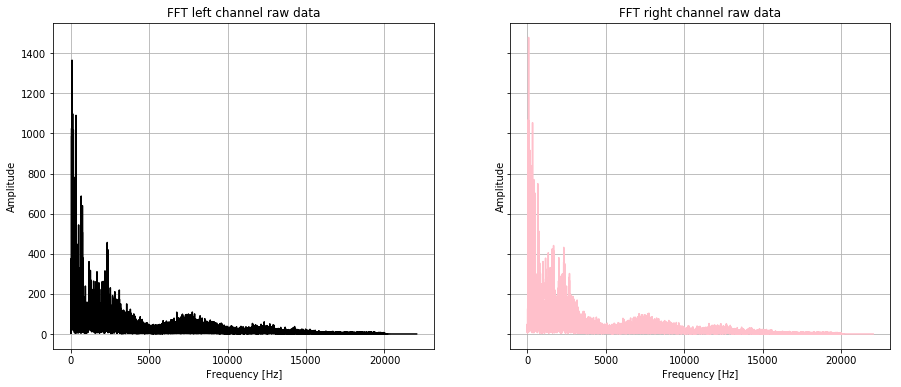

In [13]:
plot_fftx((leftchan,rightchan),("FFT left channel raw data", "FFT right channel raw data"),("black","pink"))

## Test FIR filter
To test the low-pass, band-pass and high-pass FIR filters, a section of the left audio channel is filtered as follows.

In [14]:
# lowpass
mat = scipy.io.loadmat('num_lp.mat') # load matlab file
num = np.array(mat['num']) # retrieve numerator from matlab file
num_lp = np.concatenate(num) # convert to scalar vector
# bandpass
mat = scipy.io.loadmat('num_bp.mat') # load matlab file
num = np.array(mat['num']) # retrieve numerator from matlab file
num_bp = np.concatenate(num) # convert to scalar vector
# highpass
mat = scipy.io.loadmat('num_hp.mat') # load matlab file
num = np.array(mat['num']) # retrieve numerator from matlab file
num_hp = np.concatenate(num) # convert to scalar vector

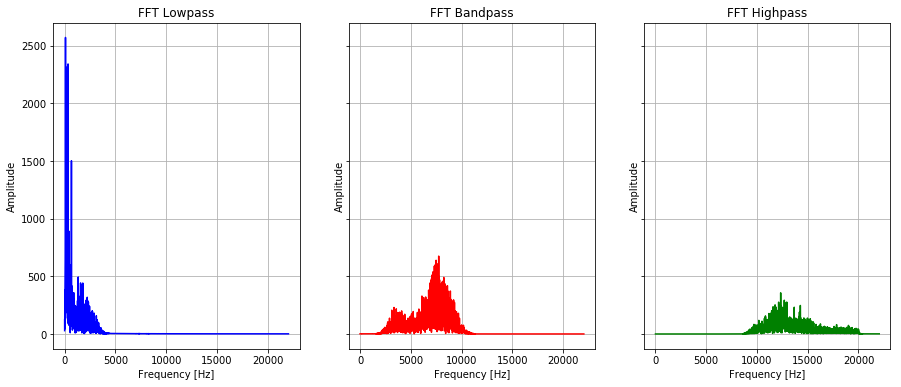

In [15]:
# description: function to apply lowpass, bandpass and highpass to one sample value
    # sample_in: np.float32
    # buffer: numpy array of np.float32
    # return: np.float32, np.float32, np.float32
def filter_sample(sample_in,buffer):
    # [new 0 ..... 50 old]
    buffer = np.delete(buffer,FILTER_SIZE-1) # remove latest sample from buffer
    temp = np.array([sample_in],dtype=np.float32)
    buffer = np.concatenate((temp,buffer)) # add new sample to buffer
    # apply filter
    sample_out_lp = 0
    sample_out_bp = 0
    sample_out_hp = 0
    for i in range(FILTER_SIZE):
        sample_out_lp = sample_out_lp + buffer[i] * num_lp[i]
        sample_out_bp = sample_out_bp + buffer[i] * num_bp[i]
        sample_out_hp = sample_out_hp + buffer[i] * num_hp[i]
    return sample_out_lp,sample_out_bp,sample_out_hp,buffer

# description: function to apply lowpass, bandpass and highpass to sample array
    # sample_array_in: numpy array of np.float32
def filter_samples(sample_array_in):
    buffer = np.zeros(FILTER_SIZE,dtype=np.float32)
    sample_array_out_lp = np.zeros(sample_array_in.size,dtype=np.float32)
    sample_array_out_bp = np.zeros(sample_array_in.size,dtype=np.float32)
    sample_array_out_hp = np.zeros(sample_array_in.size,dtype=np.float32)
    
    for i in range(sample_array_in.size):
        sample_array_out_lp[i],sample_array_out_bp[i],sample_array_out_hp[i],buffer = filter_sample(sample_array_in[i],buffer)
    return sample_array_out_lp,sample_array_out_bp,sample_array_out_hp

filter_test_in = leftchan[0:10000]
filter_test_out = filter_samples(filter_test_in)   
plot_fftx(filter_test_out,('FFT Lowpass','FFT Bandpass', 'FFT Highpass'),("blue","red","green"))

## CPU (PS) solution
Run audio mixer only with cpu.
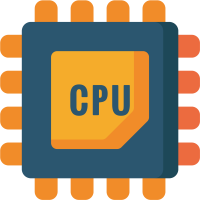

Runtime: 78.94108486175537


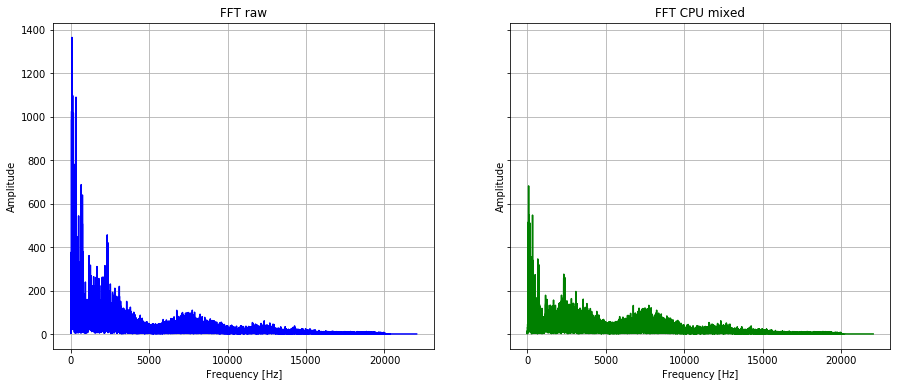

In [16]:
# description: function to apply filters and gain to one sample value
    # sample_in: np.float32
    # buffer: numpy array of np.float32
    # return: np.float32, np.float32 
def amix_cpu_sample(sample_in,buffer):
    # [new 0 ..... 50 old]
    buffer = np.delete(buffer,FILTER_SIZE-1) # remove latest sample from buffer
    temp = np.array([sample_in],dtype=np.float64)
    buffer = np.concatenate((temp,buffer)) # add new sample to buffer
    # apply filter
    sample_out_lp = 0
    sample_out_bp = 0
    sample_out_hp = 0
    for i in range(FILTER_SIZE):
        sample_out_lp += (buffer[i] * num_lp[i])
        sample_out_bp += (buffer[i] * num_bp[i])
        sample_out_hp += (buffer[i] * num_hp[i])
    # apply gain   
    sample_out_lp *= gain_bass
    sample_out_bp *= gain_mid
    sample_out_hp *= gain_treble
    
    return (sample_out_lp+sample_out_bp+sample_out_hp),buffer

# description: function to apply filters and gain to sample array
    # sample_array_in: numpy array of np.float32
    # return: numpy array of np.float32, float
def amix_cpu(sample_array_in):
    # initialize output array
    sample_array_out = np.zeros(sample_array_in.size,dtype=np.float32)
    
    buffer = np.zeros(FILTER_SIZE,dtype=np.float64)
    
    start_time = time.time() 
    # loop through sample values
    for i in range(sample_array_in.size):
        sample_array_out[i],buffer = amix_cpu_sample(sample_array_in[i],buffer)

    stop_time = time.time() 
    
    return sample_array_out, stop_time-start_time

data_cpu,time_cpu = amix_cpu(leftchan)

print("Runtime: "+ str(time_cpu))
plot_fftx((leftchan,data_cpu),('FFT raw', 'FFT CPU mixed'),('blue','green'))

## FPGA (PL) solution
Run audio mixer with the help of the FPGA
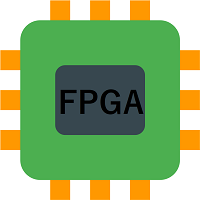

Runtime: 28.735196113586426


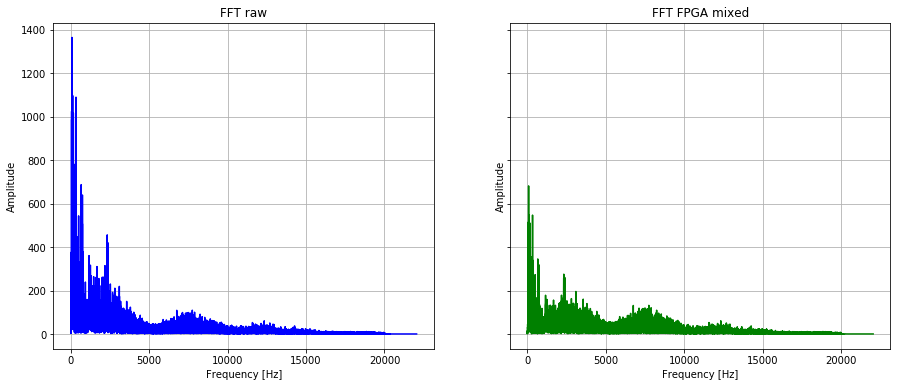

In [17]:
# description: function to apply filters and gain to sample array
    # sample_array_in: numpy array of np.float32
    # return: numpy array of np.float32, float
def amix_fpga(sample_array_in):
    # apply overlay
    overlay = Overlay('overlay.bit')
    regs = overlay.amix.register_map
    
    # initialize output array
    sample_array_out = np.zeros(sample_array_in.size,dtype=np.float32)
    
    start_time = time.time()
    
    # set gain registers one
    regs.gain_lp = int.from_bytes(struct.pack('>f', gain_bass), "big")
    regs.gain_bp = int.from_bytes(struct.pack('>f',gain_mid), "big")
    regs.gain_hp = int.from_bytes(struct.pack('>f', gain_treble), "big")
    
    # loop through sample values
    for i in range(sample_array_in.size):
        # set input sample     
        regs.sample_in = int.from_bytes(struct.pack('>f', sample_array_in[i]), "big")

        regs.CTRL.AP_START = 1 
        while (regs.CTRL.AP_DONE != 1):
            pass
        
        sample_array_out[i] = struct.unpack('>f',regs.ap_return.ap_return.to_bytes(4, 'big'))[0]
        
    stop_time = time.time()  
    
    return sample_array_out,stop_time-start_time

data_fpga,time_fpga  = amix_fpga(leftchan)  

print("Runtime: "+ str(time_fpga))
plot_fftx((leftchan,data_fpga),('FFT raw', 'FFT FPGA mixed'),('blue','green'))


## Can you hear the difference ?
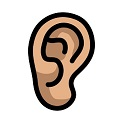

In [18]:
# Save left channel raw samples
leftchan = leftchan.astype(np.int16)
sf.write('test_in.wav',leftchan, SAMPLERATE)
print("Try out the raw song!")
wavPlayer('test_in.wav')

# Save left channel mixed samples
data_fpga = data_fpga.astype(np.int16)
sf.write('test_out.wav',data_fpga, SAMPLERATE)
print("Try out the mixed song!")
wavPlayer('test_out.wav')



Try out the raw song!


Try out the mixed song!


## Comparison PS vs PL

In [19]:
NUM_ITER = 6 # Number of Samples:  10 ... 10^NUM_ITER in logarithmic scale
time_fpga = np.zeros(NUM_ITER)
time_cpu = np.zeros(NUM_ITER)
test_size = np.logspace(1,NUM_ITER, num = NUM_ITER, dtype = np.int)

for i in range(NUM_ITER):
    print("Time measurement with " + str(test_size[i])+ " samples.")
    _,time_fpga[i]  = amix_fpga(audio[0: test_size[i]]) 
    _,time_cpu[i]   = amix_cpu(audio[0: test_size[i]])




Time measurement with 10 samples.
Time measurement with 100 samples.
Time measurement with 1000 samples.
Time measurement with 10000 samples.
Time measurement with 100000 samples.
Time measurement with 1000000 samples.


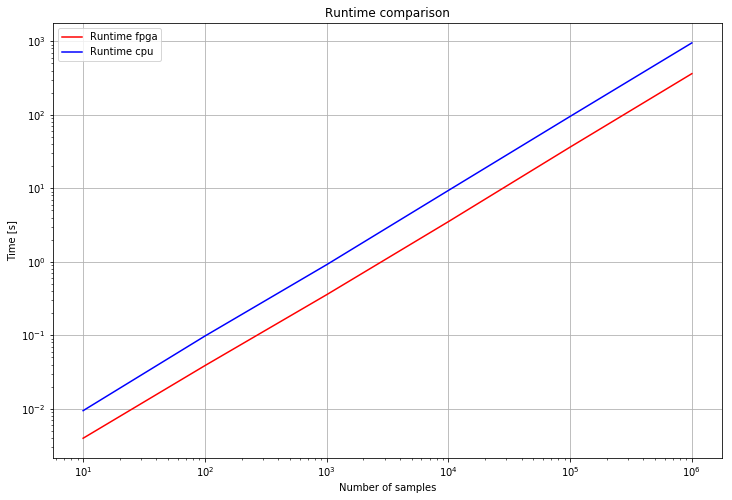

In [20]:
plt.loglog(test_size,time_fpga,label='Runtime fpga',color = 'red')
plt.loglog(test_size,time_cpu,label='Runtime cpu',color = 'blue')
plt.title('Runtime comparison')
plt.xlabel('Number of samples')
plt.ylabel('Time [s]')
plt.legend()
plt.grid()
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)
plt.show()

## Speedup
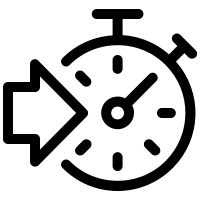

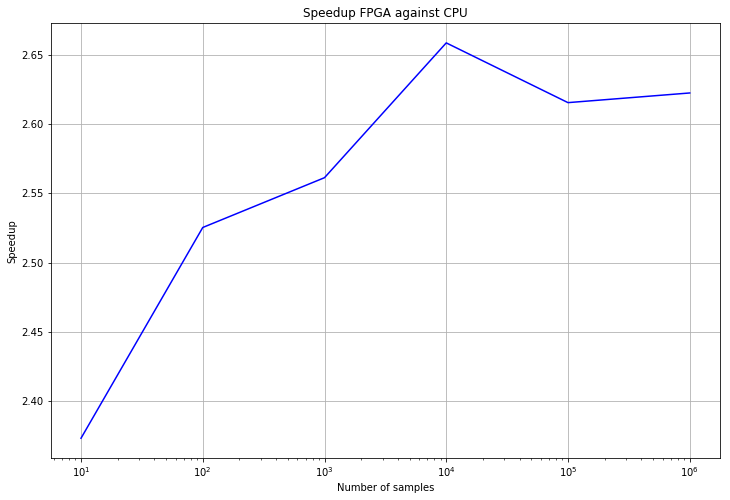

In [21]:
plt.semilogx(test_size,time_cpu/time_fpga,color = 'blue')
plt.title('Speedup FPGA against CPU')
plt.xlabel('Number of samples')
plt.ylabel('Speedup')
plt.grid()
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)
plt.show()